# $$ \text{Experiments Keyword Extraction} $$

## Import libraries

In [1]:
from pyspark.sql import SparkSession, functions as F, types as T
from pyspark.sql.window import Window
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer, IDF, NGram
from pyspark.ml import Pipeline

from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8"); sns.set_theme(style="whitegrid", palette="Set2")

import math, re, os
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
tqdm.pandas()

## Create SparkSession and Data URLs

In [2]:
spark = SparkSession.builder.appName("kw-exp").getOrCreate()
spark.conf.set("spark.sql.shuffle.partitions", "200")

In [3]:
DATA_RAW   = "/opt/data/raw"
DATA_GOLD  = "/opt/data/gold"

## Load Raw Data (.parquet)

In [ ]:
df_raw = spark.read.parquet(f"{DATA_RAW}/**/*.parquet")
df_raw.show(5)

In [ ]:
df_raw.count()

In [ ]:
# Select target columns
df_doc = df_raw.select("uid", "year", "title", "abstract", "doc_text")
df_doc.show(5)

## Tokenization and Remove StopWords

In [ ]:
tok = RegexTokenizer(inputCol="doc_text", outputCol="tokens", pattern="\\W+", toLowercase=True, minTokenLength=2)

custom_stop = ["we","our","paper","show","result","results","approach", "experiments", "also",
               "method","methods","propose","introduction","related","work", "systems",
               "section","figure","table","study","based","using","model",
               "data","analysis","problem","task","algorithm","performance"]
sw = StopWordsRemover(inputCol="tokens", outputCol="tokens_sw")
sw = sw.setStopWords(sw.getStopWords() + custom_stop)

## N-Gram

In [ ]:
ng2 = NGram(n=2, inputCol="tokens_sw", outputCol="bigrams")

@F.udf("array<string>")
def merge_terms(tokens_sw, bigrams):
    if tokens_sw is None:
        tokens_sw = []
    if bigrams is None:
        bigrams = []
    terms = list(tokens_sw)

    for bg in bigrams:
        if not bg:
            continue
        w1, w2 = bg.split()
        if w1 in custom_stop or w2 in custom_stop:
            continue
        terms.append(bg)

    seen = set()
    uniq = []
    for t in terms:
        if t not in seen:
            seen.add(t)
            uniq.append(t)
    return uniq

## Create Pipeline Preprocess

In [ ]:
# Pipeline preprocess
pipe = Pipeline(stages=[tok, sw, ng2])
pp = pipe.fit(df_doc)

# Preprocessed Data
df_pp = (
    pp.transform(df_doc)
    .withColumn(
        "terms", 
        merge_terms(F.col("tokens_sw"), F.col("bigrams"))
    )
)

df_pp.show(5)

# $$ \text{Term Frequency - Inverse Document Frequency (TF-IDF)} $$ 

In [ ]:
# Stage TF and IDF
cv = CountVectorizer(inputCol="terms", outputCol="tf", minDF=3)
idf = IDF(inputCol="tf", outputCol="tfidf")

# Fit, Transform
cv_model = cv.fit(df_pp)
df_tf = cv_model.transform(df_pp)

idf_model = idf.fit(df_tf)
df_tfidf = idf_model.transform(df_tf)

## Keyword Extraction (TF-IDF)

In [ ]:
# Max keyword
K = 10

# Vocab pretrained from CountVectorizer
vocab = cv_model.vocabulary

In [ ]:
# UDF: List top-K term (by name) from vector TF-IDF
@F.udf("array<string>")
def topk_terms(v):
    if v is None: return []
    idx = list(v.indices)
    val = list(v.values)
    pairs = sorted(zip(idx, val), key=lambda x: x[1], reverse=True)[:K]
    return [vocab[i] for i,_ in pairs]

# UDF: List top-K score (by TF-IDF Score) corresponding with terms
@F.udf("array<double>")
def topk_scores(v):
    if v is None: return []
    idx = list(v.indices)
    val = list(v.values)
    pairs = sorted(zip(idx, val), key=lambda x: x[1], reverse=True)[:K]
    return [float(s) for _,s in pairs]

In [ ]:
# Extract Keyword per Doc
df_kw_tfidf = (
    df_tfidf
    .select(
        "uid","year",
        topk_terms("tfidf").alias("keywords"),
        topk_scores("tfidf").alias("scores")
    )
    # Add "method" column to mark extraction method (here is tfidf),
    # later can add TextRank, KeyBERT,... common schema
    .withColumn("method", F.lit("tfidf"))
)


df_kw_tfidf.show(5)

In [ ]:
# Change from "each line = 1 document with list keyword" to "each line = 1 keyword"
df_kw_tfidf_long = (
    df_kw_tfidf
    .select(
        "uid","year","method",
        # posexplode_outer(keywords) splits the keywords array into multiple lines:
        #   - rank: index position in the array (0,1,2,...) = keyword rank
        #   - keyword: string value
        F.posexplode_outer("keywords").alias("rank","keyword"),
        F.col("scores").getItem(F.col("rank")).alias("score")
    )
    .withColumn("rank", F.col("rank").cast("long"))
)

df_kw_tfidf_long.show(5)

# $$ \text{KeyBERT-style (Embedding-based)} $$

## Load model

In [ ]:
# !pip install -q keybert sentence-transformers

In [ ]:
model = SentenceTransformer('all-MiniLM-L6-v2')

## Keyword Extraction (KeyBERT-style)

In [ ]:
def keybert_like(doc, terms, top_k=K):
    if not doc or not terms:
        return [], []

    seen = set()
    cand = []
    for t in terms:
        if t not in seen:
            seen.add(t)
            cand.append(t)
    if not cand:
        return [], []

    doc_emb = model.encode([doc], normalize_embeddings=True)[0]
    term_emb = model.encode(cand, normalize_embeddings=True)
    
    # cosine = dot, because normalized
    scores = term_emb @ doc_emb

    idx = scores.argsort()[::-1][:top_k]
    kws = [cand[i] for i in idx]
    scr = [float(scores[i]) for i in idx]
    return kws, scr

In [ ]:
# Convert Dataframe, to avoid crash
pdf = (
    df_pp
    .select("uid", "year", "doc_text", "terms")
    .where(F.size("terms") > 0)
    .toPandas()
)

results = pdf.progress_apply(
    lambda row: keybert_like(row["doc_text"], row["terms"]),
    axis=1
)

pdf["keywords"] = results.apply(lambda x: x[0])
pdf["scores"]   = results.apply(lambda x: x[1])

In [ ]:
# Change from "each line = 1 document with list keyword" to "each line = 1 keyword"

rows = []
for _, row in pdf.iterrows():
    uid = row["uid"]
    year = row["year"]
    kws = row["keywords"]
    scr = row["scores"]
    for r, (k, s) in enumerate(zip(kws, scr)):
        rows.append({
            "uid": uid,
            "year": year,
            "method": "keybert_like",
            "rank": r,
            "keyword": k,
            "score": float(s),
        })

pdf_long = pd.DataFrame(rows)
df_kw_keybert_long = spark.createDataFrame(pdf_long).withColumn("rank", F.col("rank").cast("long"))
df_kw_keybert_long.show(5)

# $$ \text{TextRank (Graph-based)} $$

## PageRank

In [ ]:
# pip install networkx

In [ ]:
import networkx as nx

In [ ]:
@F.udf("array<string>")
def textrank_terms_udf(terms: list):
    if terms is None or len(terms) == 0:
        return []
    
    # Build a co-occurrence graph
    window = 4
    G = nx.Graph()
    G.add_nodes_from(terms)
    
    # Add edges between terms in the same window
    n = len(terms)
    for i in range(n):
        for j in range(i+1, min(i+window, n)):
            if terms[i] == terms[j]:
                continue
            if G.has_edge(terms[i], terms[j]):
                G[terms[i]][terms[j]]["weight"] += 1.0
            else:
                G.add_edge(terms[i], terms[j], weight=1.0)
    
    if G.number_of_edges() == 0:
        # fallback: return simple term
        return terms[:K]
    
    # Run PageRank
    scores = nx.pagerank(G, weight="weight")
    
    # Sort by score descending, get top-K
    ranked = sorted(scores.items(), key=lambda x: x[1], reverse=True)[:K]
    return [t for t, s in ranked]

@F.udf("array<double>")
def textrank_scores_udf(terms: list):
    if terms is None or len(terms) == 0:
        return []
    
    window = 4
    G = nx.Graph()
    G.add_nodes_from(terms)
    n = len(terms)
    for i in range(n):
        for j in range(i+1, min(i+window, n)):
            if terms[i] == terms[j]:
                continue
            if G.has_edge(terms[i], terms[j]):
                G[terms[i]][terms[j]]["weight"] += 1.0
            else:
                G.add_edge(terms[i], terms[j], weight=1.0)
    
    if G.number_of_edges() == 0:
        return [1.0] * min(K, len(terms))
    
    scores = nx.pagerank(G, weight="weight")
    ranked = sorted(scores.items(), key=lambda x: x[1], reverse=True)[:K]
    return [float(s) for t, s in ranked]

## Keyword Extraction (TextRank)

In [ ]:
df_kw_textrank = (
    df_pp
    .select(
        "uid",
        "year",
        textrank_terms_udf(F.col("terms")).alias("keywords"),
        textrank_scores_udf(F.col("terms")).alias("scores")
    )
    .withColumn("method", F.lit("textrank"))
)

df_kw_textrank.show(5)

In [ ]:
df_kw_textrank_long = df_kw_textrank.select(
    "uid", "year", "method",
    F.posexplode_outer(F.col("keywords")).alias("rank", "keyword"),
    F.col("scores").getItem(F.col("rank")).alias("score")
).withColumn("rank", F.col("rank").cast("long"))

df_kw_textrank_long.show(5)

## Store

In [ ]:
from functools import reduce

dfs = [df_kw_tfidf_long, df_kw_keybert_long, df_kw_textrank_long]

for i in range(len(dfs)):
    dfs[i] = (dfs[i]
              .select("uid","year","method","rank","keyword","score")
              .withColumn("rank", F.col("rank").cast("long"))
              .withColumn("score", F.col("score").cast("double")))

df_kw_all = reduce(lambda a,b: a.unionByName(b), dfs)

df_kw_all.printSchema()
df_kw_all.show(5)

In [ ]:
df_kw_all.write.mode("overwrite") \
    .partitionBy("method","year") \
    .parquet(f"{DATA_GOLD}/keywords")

# $$ \text{Evaluate} $$

## Predicted Data

In [4]:
DATA_GOLD = "/opt/data/gold"
DATA_BRONZE = "/opt/data/raw"

In [5]:
df_pred_long = spark.read.parquet(f"{DATA_GOLD}/keywords")

df_pred_long.printSchema()
df_pred_long.show(5, truncate=True)

root
 |-- uid: string (nullable = true)
 |-- rank: long (nullable = true)
 |-- keyword: string (nullable = true)
 |-- score: double (nullable = true)
 |-- method: string (nullable = true)
 |-- year: integer (nullable = true)

+--------------------+----+----------------+-------------------+------------+----+
|                 uid|rank|         keyword|              score|      method|year|
+--------------------+----+----------------+-------------------+------------+----+
|30892f6cf921ca622...|   4|       coco 2016| 0.4543645977973938|keybert_like|2017|
|30892f6cf921ca622...|   5|object detection|0.44932490587234497|keybert_like|2017|
|30892f6cf921ca622...|   6|        cnn easy| 0.4489985406398773|keybert_like|2017|
|30892f6cf921ca622...|   7|      cnn simple| 0.4464990198612213|keybert_like|2017|
|30892f6cf921ca622...|   8|             cnn| 0.4455605149269104|keybert_like|2017|
+--------------------+----+----------------+-------------------+------------+----+
only showing top 5 rows

+-

In [6]:
df_openalex = spark.read.parquet(f"{DATA_BRONZE}/**/*.parquet")

df_openalex.select("uid", "title", "doc_text", "keywords_gold").show(5)

+--------------------+--------------------+--------------------+--------------------+
|                 uid|               title|            doc_text|       keywords_gold|
+--------------------+--------------------+--------------------+--------------------+
|7a3057fb54678e14f...|Global cancer sta...|Global cancer sta...|[Cancer, Medicine...|
|3dff4f365c658b9f7...|A Multi-Modal Dis...|A Multi-Modal Dis...|[Computer science...|
|19548f39e97f34863...|On a Method to Me...|On a Method to Me...|[Interpretability...|
|e563dea4f55bc5e37...|Quantifying the S...|Quantifying the S...|[Computer science...|
|b92633b5d1b7553f6...|8 Decolonizing Me...|8 Decolonizing Me...|[Indigenous, Adve...|
+--------------------+--------------------+--------------------+--------------------+
only showing top 5 rows



## Collect keyword list (sorted by rank)

In [7]:
df_pred = (
    df_pred_long
    .groupBy("uid", "method")
    .agg(
        F.sort_array(
            F.collect_list(F.struct("rank", "keyword")),
            asc=True
        ).alias("kw_structs")
    )
    .select(
        "uid", "method",
        F.expr("transform(kw_structs, x -> x.keyword)").alias("pred_keywords")
    )
)

df_pred.show(5)

+--------------------+------------+--------------------+
|                 uid|      method|       pred_keywords|
+--------------------+------------+--------------------+
|001af04a31c0a900e...|keybert_like|[strain sensing, ...|
|001f4fe99c63d900a...|    textrank|[opportunities ne...|
|00359337c15380c31...|    textrank|[support unlimite...|
|00572c6774c31dfd2...|    textrank|[information supp...|
|00601383c1d031a72...|    textrank|[guideline, thera...|
+--------------------+------------+--------------------+
only showing top 5 rows



## Normalize

In [8]:
@F.udf("array<string>")
def normalize_terms(arr):
    import re
    if arr is None:
        return []
    out = []
    for t in arr:
        if not t:
            continue
        s = str(t).lower().strip()
        s = re.sub(r"[\u2010-\u2015\-_/]", " ", s)
        s = re.sub(r"[^a-z0-9\s]", " ", s)
        s = re.sub(r"\s+", " ", s).strip()
        if len(s) < 2:
            continue
        out.append(s)

    # unique preserve order
    seen = set()
    uniq = []
    for x in out:
        if x not in seen:
            seen.add(x)
            uniq.append(x)
    return uniq

df_pred_n = df_pred.withColumn("pred_norm", normalize_terms("pred_keywords"))
df_gold_base = df_openalex.select("uid", "title", "doc_text", "keywords_gold", "silver_title")
df_gold_k = df_gold_base.withColumn("gold_norm", normalize_terms("keywords_gold"))
df_gold_s = df_gold_base.withColumn("gold_norm", normalize_terms("silver_title"))

In [9]:
def build_eval_df(df_gold_norm, label_name: str):
    # df_gold_norm: has uid, doc_text, gold_norm
    df_eval = (
        df_pred_n.alias("p")
        .join(df_gold_norm.select("uid", "doc_text", "gold_norm").alias("g"), on="uid", how="inner")
        .select(
            F.col("uid"),
            F.col("p.method").alias("method"),
            F.col("g.doc_text").alias("doc_text"),
            F.col("p.pred_norm").alias("pred_norm"),
            F.col("g.gold_norm").alias("gold_norm")
        )
        .withColumn("label_set", F.lit(label_name))
    )
    return df_eval

df_eval_k = build_eval_df(df_gold_k, "keywords_gold")
df_eval_s = build_eval_df(df_gold_s, "silver_title")

## Metrics

In [10]:
Ks = [5, 10, 20]

metric_schema = T.StructType([
    T.StructField("K", T.IntegerType()),
    T.StructField("precision", T.DoubleType()),
    T.StructField("recall", T.DoubleType()),
    T.StructField("f1", T.DoubleType()),
])

@F.udf(T.ArrayType(metric_schema))
def prf_at_k(pred, gold):
    if pred is None: pred = []
    if gold is None or len(gold) == 0:
        return []
    gset = set(gold)
    out = []
    for K in Ks:
        topk = pred[:K]
        if not topk:
            prec = 0.0
            inter = 0
        else:
            inter = len([t for t in topk if t in gset])
            prec = inter / len(topk)
        rec = inter / len(gold)
        f1 = 0.0 if (prec + rec == 0) else 2 * prec * rec / (prec + rec)
        out.append({
            "K": int(K),
            "precision": float(prec),
            "recall": float(rec),
            "f1": float(f1),
        })
    return out

@F.udf("double")
def mrr_at_k(pred, gold, K):
    if not gold:
        return 0.0
    gset = set(gold)
    topk = pred[:K] if pred else []
    for i, w in enumerate(topk, start=1):
        if w in gset:
            return 1.0 / i
    return 0.0

@F.udf("double")
def map_at_k(pred, gold, K):
    if pred is None: pred = []
    if gold is None or len(gold) == 0:
        return 0.0
    gset = set(gold)
    hits = 0
    sum_prec = 0.0
    for i, t in enumerate(pred[:K], start=1):
        if t in gset:
            hits += 1
            sum_prec += hits / i
    if hits == 0:
        return 0.0
    return float(sum_prec / hits)

@F.udf("double")
def ndcg_at_k(pred, gold, K):
    if pred is None: pred = []
    if gold is None or len(gold) == 0:
        return 0.0
    gset = set(gold)
    dcg = 0.0
    for i, t in enumerate(pred[:K], start=1):
        rel = 1.0 if t in gset else 0.0
        if rel > 0:
            dcg += rel / math.log2(i + 1)
    G = min(len(gold), K)
    idcg = sum(1.0 / math.log2(i + 1) for i in range(1, G + 1))
    if idcg == 0:
        return 0.0
    return float(dcg / idcg)

In [11]:
def summarize_all(df_eval):
    # PRF
    df_prf = df_eval.select(
        "uid","method","label_set",
        prf_at_k("pred_norm","gold_norm").alias("m5"),
        prf_at_k("pred_norm","gold_norm").alias("m10"),
        prf_at_k("pred_norm","gold_norm").alias("m20")
    ).select(
        "uid","method","label_set",
        F.lit(5).alias("K"), F.col("m5").getItem(0).getField("precision").alias("precision"), F.col("m5").getItem(0).getField("recall").alias("recall"), F.col("m5").getItem(0).getField("f1").alias("f1")
    ).unionByName(
        df_eval.select("uid","method","label_set",
            prf_at_k("pred_norm","gold_norm").alias("m10")
        ).select(
            "uid","method","label_set",
            F.lit(10).alias("K"), F.col("m10").getItem(1).getField("precision").alias("precision"), F.col("m10").getItem(1).getField("recall").alias("recall"), F.col("m10").getItem(1).getField("f1").alias("f1")
        ).selectExpr("uid","method","label_set","K as K","precision as precision","recall as recall","f1 as f1")
    ).unionByName(
        df_eval.select("uid","method","label_set",
            prf_at_k("pred_norm","gold_norm").alias("m20")
        ).select(
            "uid","method","label_set",
            F.lit(20).alias("K"), F.col("m20").getItem(2).getField("precision").alias("precision"), F.col("m20").getItem(2).getField("recall").alias("recall"), F.col("m20").getItem(2).getField("f1").alias("f1")
        ).selectExpr("uid","method","label_set","K as K","precision as precision","recall as recall","f1 as f1")
    )

    df_prf_summary = (
        df_prf.groupBy("method","label_set","K")
        .agg(F.avg("precision").alias("precision"), F.avg("recall").alias("recall"), F.avg("f1").alias("f1"))
        .orderBy("label_set","K","method")
    )

    # MRR
    df_mrr = df_eval.select(
        "method","label_set",
        mrr_at_k("pred_norm","gold_norm",F.lit(5)).alias("MRR5"),
        mrr_at_k("pred_norm","gold_norm",F.lit(10)).alias("MRR10"),
    )
    df_mrr_summary = (
        df_mrr.groupBy("method","label_set")
        .agg(F.avg("MRR5").alias("MRR5"), F.avg("MRR10").alias("MRR10"))
        .orderBy("label_set","method")
    )

    # MAP
    df_map = df_eval.select(
        "method","label_set",
        map_at_k("pred_norm","gold_norm",F.lit(5)).alias("MAP5"),
        map_at_k("pred_norm","gold_norm",F.lit(10)).alias("MAP10"),
    )
    df_map_summary = (
        df_map.groupBy("method","label_set")
        .agg(F.avg("MAP5").alias("MAP5"), F.avg("MAP10").alias("MAP10"))
        .orderBy("label_set","method")
    )

    # nDCG
    df_ndcg = df_eval.select(
        "method","label_set",
        ndcg_at_k("pred_norm","gold_norm",F.lit(5)).alias("nDCG5"),
        ndcg_at_k("pred_norm","gold_norm",F.lit(10)).alias("nDCG10"),
    )
    df_ndcg_summary = (
        df_ndcg.groupBy("method","label_set")
        .agg(F.avg("nDCG5").alias("nDCG5"), F.avg("nDCG10").alias("nDCG10"))
        .orderBy("label_set","method")
    )

    return df_prf_summary, df_mrr_summary, df_map_summary, df_ndcg_summary

prf_k, mrr_k, map_k, ndcg_k = summarize_all(df_eval_k)
prf_s, mrr_s, map_s, ndcg_s = summarize_all(df_eval_s)

prf_k.show(50)
prf_s.show(50)

+------------+-------------+---+--------------------+--------------------+--------------------+
|      method|    label_set|  K|           precision|              recall|                  f1|
+------------+-------------+---+--------------------+--------------------+--------------------+
|keybert_like|keywords_gold|  5| 0.07315175097276301| 0.03323001889393966| 0.04400262136321144|
|    textrank|keywords_gold|  5| 0.04574146130566378|0.020611662259622878| 0.02749368829979874|
|       tfidf|keywords_gold|  5|0.031168035740020163|0.013521137772619016| 0.01821007210629141|
|keybert_like|keywords_gold| 10| 0.06399397127347842| 0.05796291596914646|0.058404962426428224|
|    textrank|keywords_gold| 10|0.035759835711197785| 0.03129182593511057| 0.03232260295316909|
|       tfidf|keywords_gold| 10| 0.03432230869001315|0.029637884783695122| 0.03062004019812429|
|keybert_like|keywords_gold| 20| 0.06399397127347842| 0.05796291596914646|0.058404962426428224|
|    textrank|keywords_gold| 20|0.035759

In [12]:
OUT = "/opt/data/artifacts"
os.makedirs(OUT, exist_ok=True)

(prf_k.toPandas()).to_csv(f"{OUT}/prf_keywords_gold.csv", index=False)
(mrr_k.toPandas()).to_csv(f"{OUT}/mrr_keywords_gold.csv", index=False)
(map_k.toPandas()).to_csv(f"{OUT}/map_keywords_gold.csv", index=False)
(ndcg_k.toPandas()).to_csv(f"{OUT}/ndcg_keywords_gold.csv", index=False)

(prf_s.toPandas()).to_csv(f"{OUT}/prf_silver_title.csv", index=False)
(mrr_s.toPandas()).to_csv(f"{OUT}/mrr_silver_title.csv", index=False)
(map_s.toPandas()).to_csv(f"{OUT}/map_silver_title.csv", index=False)
(ndcg_s.toPandas()).to_csv(f"{OUT}/ndcg_silver_title.csv", index=False)

print("Saved artifacts to:", OUT)

Saved artifacts to: /opt/data/artifacts


## Visualization

### WordCloud

In [13]:
# !pip -q install wordcloud

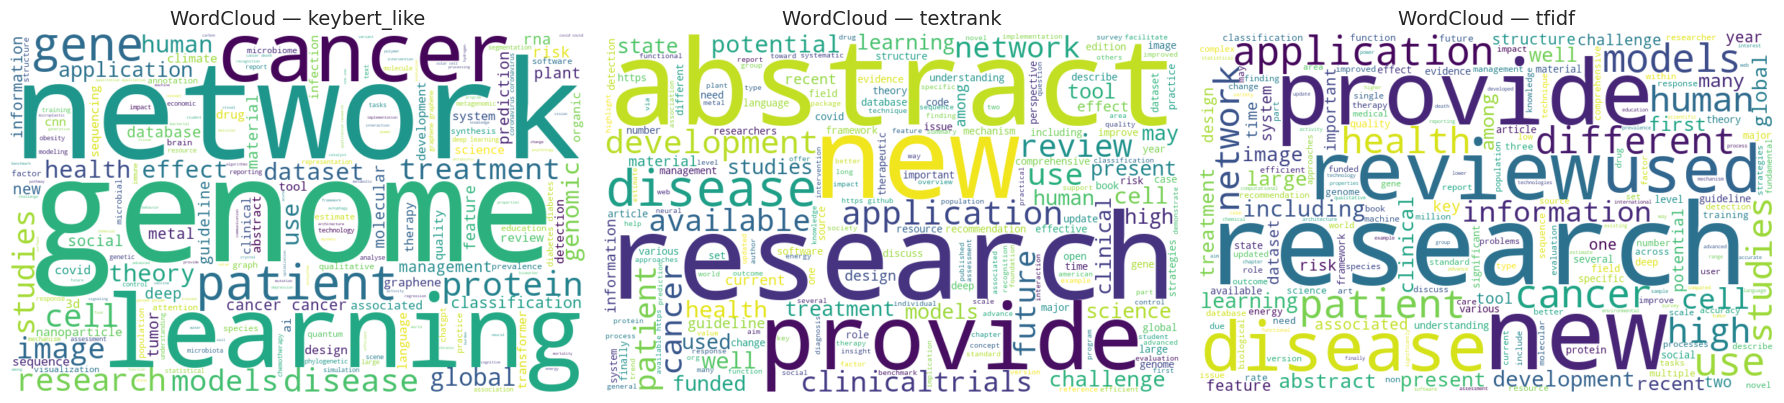

In [14]:
from wordcloud import WordCloud

pdf_pred = df_pred_long.toPandas()
pdf_pred["keyword"] = pdf_pred["keyword"].fillna("").astype(str)

methods = pdf_pred["method"].unique()
methods = sorted(methods)[:3]

plt.figure(figsize=(18, 5))

for i, m in enumerate(methods, start=1):
    sub = pdf_pred[pdf_pred["method"] == m]
    kws = [k for k in sub["keyword"] if isinstance(k, str) and k.strip() != ""]
    text = " ".join(kws)

    wc = WordCloud(width=800, height=500, background_color="white").generate(text)
    
    plt.subplot(1, 3, i)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"WordCloud — {m}", fontsize=14)

plt.tight_layout()
plt.show()

### Keyword Overlap Matrix (Jaccard)

In [15]:
df_method_kw = (
    df_pred_long.groupBy("method")
    .agg(F.collect_set("keyword").alias("kw_set"))
)
pdf_method_kw = df_method_kw.toPandas()

In [16]:
methods = pdf_method_kw["method"].tolist()
kw_sets = {row["method"]: set(row["kw_set"]) for _, row in pdf_method_kw.iterrows()}

mat = np.zeros((len(methods), len(methods)))

for i,m1 in enumerate(methods):
    for j,m2 in enumerate(methods):
        inter = len(kw_sets[m1].intersection(kw_sets[m2]))
        union = len(kw_sets[m1].union(kw_sets[m2]))
        mat[i,j] = inter/union if union>0 else 0

df_overlap = pd.DataFrame(mat, index=methods, columns=methods)

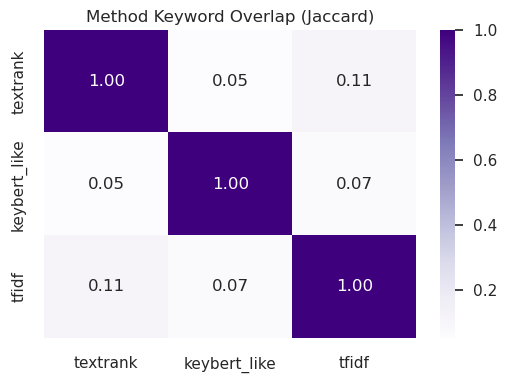

In [17]:
plt.figure(figsize=(6,4))
sns.heatmap(df_overlap, annot=True, cmap="Purples", fmt=".2f")
plt.title("Method Keyword Overlap (Jaccard)")
plt.show()

### Semantic Similarity Distribution

In [18]:
df_sem = (
    df_pred_n.alias("p")
    .join(
        df_gold_k.select("uid", "doc_text", "gold_norm").alias("g"),
        on="uid",
        how="inner"
    )
    .filter(F.size("gold_norm") > 0)
    .select("uid", "method", "doc_text", "pred_norm", "gold_norm")
)

df_sem.show(5)

+--------------------+------------+--------------------+--------------------+--------------------+
|                 uid|      method|            doc_text|           pred_norm|           gold_norm|
+--------------------+------------+--------------------+--------------------+--------------------+
|001af04a31c0a900e...|keybert_like|Stretchable, Skin...|[strain sensing, ...|[materials scienc...|
|00359337c15380c31...|    textrank|The UNITE databas...|[support unlimite...|[biology, identif...|
|00572c6774c31dfd2...|    textrank|GROMACS 4.5: a hi...|[information supp...|[computer science...|
|00601383c1d031a72...|    textrank|CDC Clinical Prac...|[guideline, thera...|[medicine, guidel...|
|008b39f495394b8a5...|keybert_like|Analisis Laporan ...|[analisis laporan...|[business adminis...|
+--------------------+------------+--------------------+--------------------+--------------------+
only showing top 5 rows



In [19]:
pdf_eval = df_sem.sample(0.1).limit(2000).toPandas()

In [20]:
embedder = SentenceTransformer("all-MiniLM-L6-v2")

def sem_sim_topk(pred, doc, k=5):
    if not pred or not doc:
        return 0.0
    kws = pred[:k]
    emb_kw = embedder.encode(kws, normalize_embeddings=True)
    emb_doc = embedder.encode([doc], normalize_embeddings=True)[0]
    sims = emb_kw @ emb_doc
    return float(np.mean(sims))

In [21]:
pdf_eval["sem_sim"] = pdf_eval.progress_apply(
    lambda r: sem_sim_topk(r["pred_norm"], r["doc_text"]), axis=1
)

  0%|          | 0/1342 [00:00<?, ?it/s]

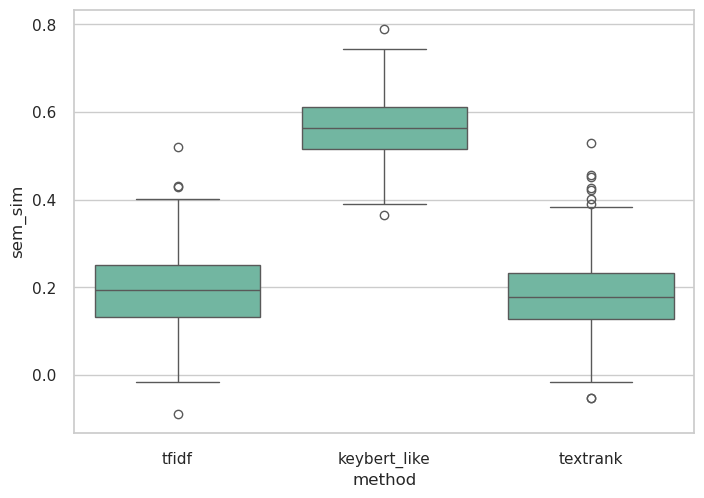

In [22]:
sns.boxplot(data=pdf_eval, x="method", y="sem_sim")
plt.show()

  0%|          | 0/1342 [00:00<?, ?it/s]

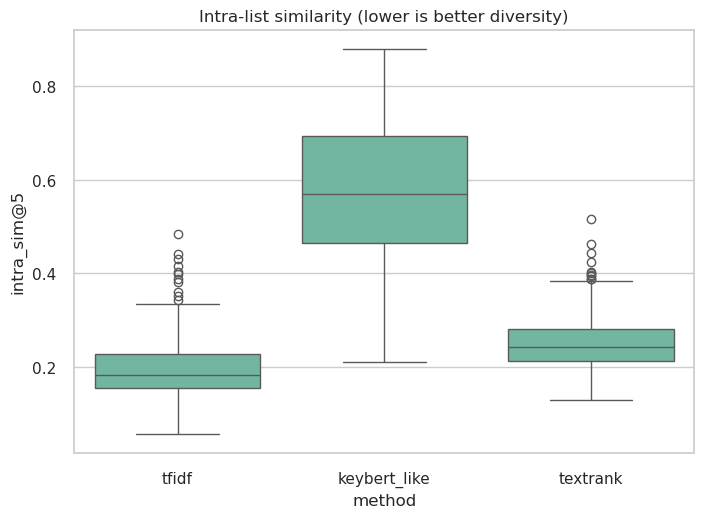

In [23]:
def intra_list_sim(pred, k=5):
    if not pred:
        return 0.0
    kws = pred[:k]
    if len(kws) <= 1:
        return 0.0
    emb = embedder.encode(kws, normalize_embeddings=True)
    sim = cosine_similarity(emb)

    n = sim.shape[0]
    vals = []
    for i in range(n):
        for j in range(i+1, n):
            vals.append(sim[i,j])
    return float(np.mean(vals)) if vals else 0.0

pdf_eval["intra_sim@5"] = pdf_eval.progress_apply(lambda r: intra_list_sim(r["pred_norm"], k=5), axis=1)
sns.boxplot(data=pdf_eval, x="method", y="intra_sim@5")
plt.title("Intra-list similarity (lower is better diversity)")
plt.show()

### Keywords Gold

**F1@K**

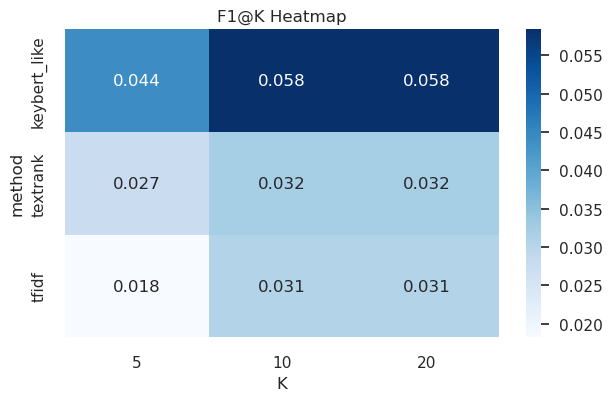

In [24]:
pdf = prf_k.toPandas()

heat = pdf.pivot(index="method", columns="K", values="f1")

plt.figure(figsize=(7,4))
sns.heatmap(heat, annot=True, cmap="Blues", fmt=".3f")
plt.title("F1@K Heatmap")
plt.show()

**MAP and nDCG**

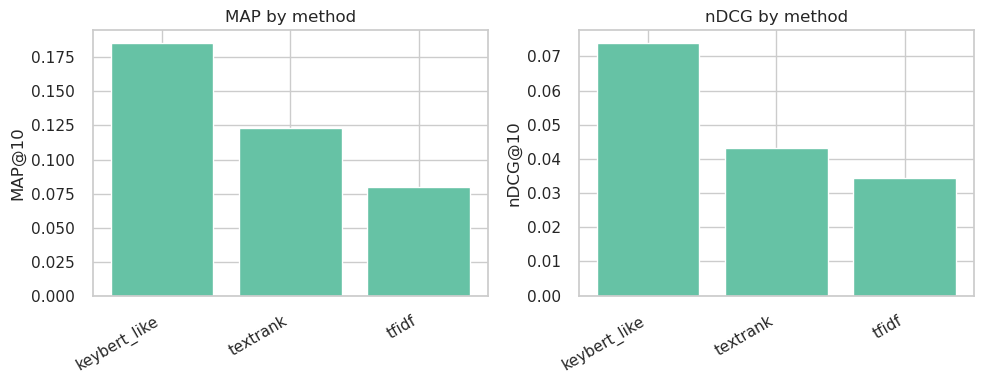

In [25]:
pdf_map = map_k.toPandas()
pdf_ndcg = ndcg_k.toPandas()

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.bar(pdf_map["method"], pdf_map["MAP10"])
plt.ylabel("MAP@10")
plt.xticks(rotation=30, ha="right")
plt.title("MAP by method")

plt.subplot(1,2,2)
plt.bar(pdf_ndcg["method"], pdf_ndcg["nDCG10"])
plt.ylabel("nDCG@10")
plt.xticks(rotation=30, ha="right")
plt.title("nDCG by method")

plt.tight_layout()
plt.show()

**Distribution of correct hits**

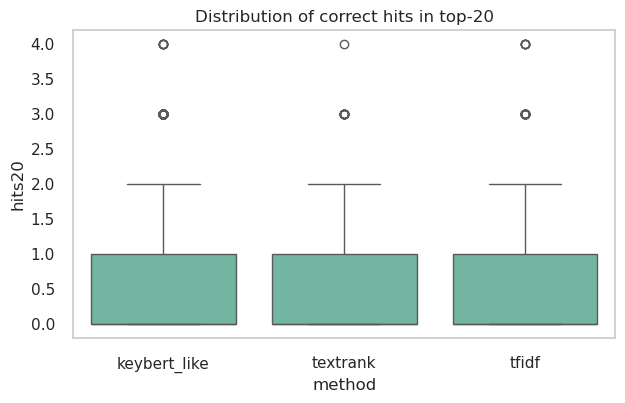

In [26]:
@F.udf("int")
def hit_count(pred, gold):
    if not gold:
        return 0
    g = set(gold)
    return int(len([w for w in pred[:20] if w in g]))

df_hits = df_eval_k.withColumn("hits20", hit_count("pred_norm","gold_norm"))

pdf_hits = df_hits.select("method","hits20").toPandas()

plt.figure(figsize=(7,4))
sns.boxplot(data=pdf_hits, x="method", y="hits20")
plt.title("Distribution of correct hits in top-20")
plt.grid(axis="y")
plt.show()

## Sliver title

**F1@K**

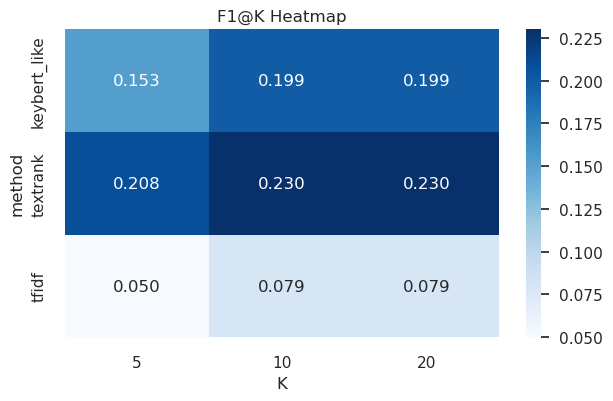

In [27]:
pdf = prf_s.toPandas()

heat = pdf.pivot(index="method", columns="K", values="f1")

plt.figure(figsize=(7,4))
sns.heatmap(heat, annot=True, cmap="Blues", fmt=".3f")
plt.title("F1@K Heatmap")
plt.show()

**MAP and nDCG**

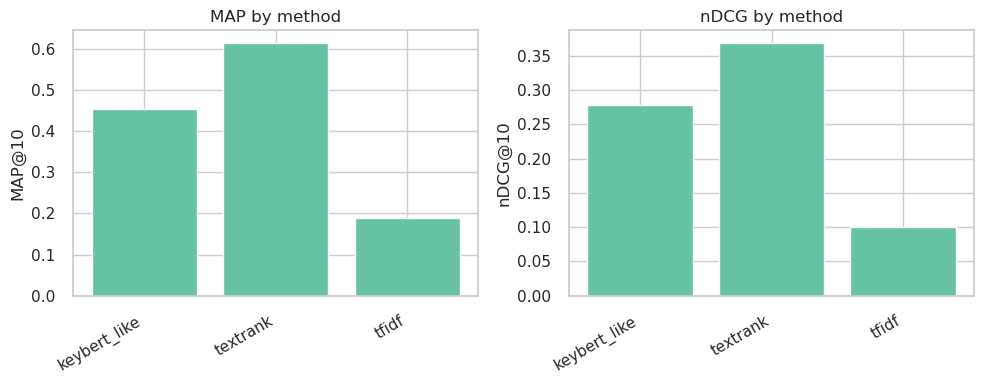

In [28]:
pdf_map = map_s.toPandas()
pdf_ndcg = ndcg_s.toPandas()

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.bar(pdf_map["method"], pdf_map["MAP10"])
plt.ylabel("MAP@10")
plt.xticks(rotation=30, ha="right")
plt.title("MAP by method")

plt.subplot(1,2,2)
plt.bar(pdf_ndcg["method"], pdf_ndcg["nDCG10"])
plt.ylabel("nDCG@10")
plt.xticks(rotation=30, ha="right")
plt.title("nDCG by method")

plt.tight_layout()
plt.show()

**Distribution of correct hits**

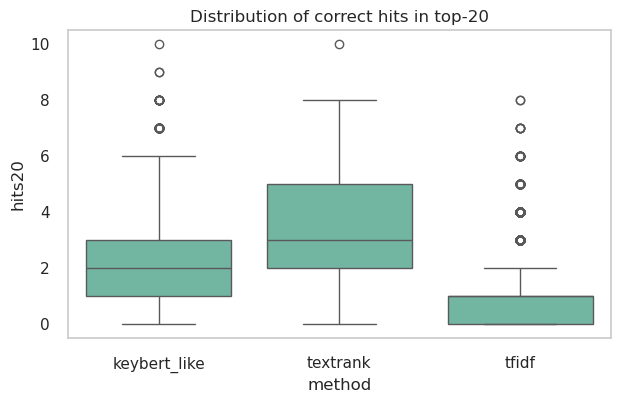

In [29]:
df_hits = df_eval_s.withColumn("hits20", hit_count("pred_norm","gold_norm"))

pdf_hits = df_hits.select("method","hits20").toPandas()

plt.figure(figsize=(7,4))
sns.boxplot(data=pdf_hits, x="method", y="hits20")
plt.title("Distribution of correct hits in top-20")
plt.grid(axis="y")
plt.show()

---